# Capstone project



## Algorithm for flower Identification App 



### Introduction

The Internet has made it easier for people to gather information on websites, and more recently through smartphones applications. 2.32 billions people possess smartphones today and this number is expected to consistenly increase throughout years. A smartphone application saves people from time consuming and slow process of seeking information from books and encyclopedias like before.

An App to identify flower can used by a flower shop to attract consumers to theirs shops, by campers/scouters, students... who are curious of nature. 


In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile  app.  At the end of this project, our code will accept any user-supplied image as input. With an image of a flower, the app will do its best to recognise it and gives its name. 


### The Road Ahead

We break the notebook into separate parts. This part concerns the model CNN(using transfer learning) & the algorithm for the flower App.


* [PART 1]: Oxford 102 flower Dataset
* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Visualise some images
* [Step 2](#step2): Preprocess the data


* [PART 2]: Create CNN to classify flowers(transfer learning)
* [Step 0](#step0): Obtain bottleneck features
* [step 1](#step1): Implement the Model Architecture
* [step 2](#step2): Train the Model 
* [step 3](#step3): Calculating classification accuracy on the test dataset


* [PART 3]: Algorithm for the App
* [Step 0](#step0): Load the list of flowers' names
* [step 1](#step1): Extract bottleneck features
* [step 2](#step2): Detect flowers on images 
* [step 3](#step3): Write the algorithm
* [step 4](#step4): Test the algorithm


<a id='step4'></a>


## PART 1: Oxford 102 Flower Dataset

## Step 0: Import Datasets

In the code cell below, we import a dataset of flower images: Oxford 102 Flower Dataset. It contains images of flowers belonging to 102 different categories. Each class/category consists of between 40 and 258 images and it has a total of 8189 images.

The datasplits used are specified in setid.mat: there is a training file (trnid), a validation file (valid)
and a testfile (tstid) and the image labels are specified in imagelabels.mat.

In [1]:
import cv2
import math
import keras
import h5py
import string
import numpy as np
import os, shutil
import time, datetime
import random

from scipy.io import loadmat
from sklearn.datasets import load_files       
from glob import glob
from keras.utils import np_utils
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Activation
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import preprocess_input
from keras.utils.np_utils import to_categorical  
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dropout, Flatten, Dense, Input, Activation, Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Conv2D

from sklearn.datasets import load_files       
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics.classification import accuracy_score, log_loss


# important for testing
img_width = 224 #168, 112, 56, 224
img_height = 224 #168, 112, 56, 224
img_size = (img_width, img_height)

def size_str():
    return "x".join([str(i) for i in img_size])

def tijdregel():
    tm = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    strp = "="* int((80-2-len(tm))/2)
    print(strp,tm,strp)

def load_dataset(path):
    data = load_files(path)
    flower_files = np.array(data['flowers'])
    flower_targets = np_utils.tocategorical(np.array(data['target']), nr_classes)
    return flower_files, flower_targets

def flower_nr_to_file(flower_nr, flower_path=""):
    """flower filenames for numbers under 10000"""
    nr = str(flower_nr)
    zeroes = (5 - len(nr)) * "0"
    filename =  "image_"+zeroes+nr+".jpg"
    if flower_path is not "":
        filename = os.path.join(flower_path, filename)
    return filename
   
print("We are using Keras version", keras.__version__)
    
tijdregel()
flower_image_path = os.path.join(os.getcwd(), "flowers")

setid_file = 'setid.mat'
setid = loadmat(setid_file)

# -1 to get 0-based files
training_indexes = setid['trnid'].flatten()-1
training_files = [flower_nr_to_file(i, flower_image_path) for i in training_indexes]

# to prepare bottleneck features
for file in training_files:
    # alle training files naar een aparte map kopieren
    # map training aanmaken (moet niet elke keer)
    destination = file.replace("flowers","train/flowers")
    # print(file, destination)
    if not os.path.exists(destination):
        shutil.copy(file, destination)
    

validation_indexes = setid['valid'].flatten()-1
validation_files = [flower_nr_to_file(i, flower_image_path) for i in validation_indexes]
validation_targets = [flower_nr_to_file(i, flower_image_path) for i in validation_indexes]
# to prepare bottleneck features
for file in validation_files:
    # alle training files naar een aparte map kopieren
    # map training aanmaken (moet niet elke keer)
    destination = file.replace("flowers","validation/flowers")
    # print(file, destination)
    if not os.path.exists(destination):
        shutil.copy(file, destination)


test_indexes = setid['tstid'].flatten()-1
test_files = [flower_nr_to_file(i, flower_image_path) for i in test_indexes]
test_targets = [flower_nr_to_file(i, flower_image_path) for i in test_indexes]


# list of flowers names 
imagelabels_file = 'imagelabels.mat'
imagelabels_data = loadmat(imagelabels_file)

imagelabels = imagelabels_data['labels'].flatten()-1
train_label = imagelabels[training_indexes]
validation_label = imagelabels[validation_indexes]
test_label = imagelabels[test_indexes]


# print statistics
nr_training_files =  len(training_files)
nr_validation_files = len(validation_files)
nr_test_files = len(test_files)
nr_files = len(imagelabels)
nr_classes = len(set(validation_label))
print("We use the following image size:", "x".join([str(i) for i in img_size]) )
print('There are %d flower training images.' % nr_training_files)
print('There are %d flower validation images.' % nr_validation_files)
print('There are %d flower test images.\n' % nr_test_files)
print('There are %d total flower images.' % nr_files)
print('There are %d flower classes.' % (nr_classes))
#print('There are %s total images.\n' % len(np.hstack([training_files, validation_files, test_files])))

Using TensorFlow backend.


We are using Keras version 2.1.2
=============================== 2018-01-27 09:39 ===============================
We use the following image size: 224x224
There are 1020 flower training images.
There are 1020 flower validation images.
There are 6149 flower test images.

There are 8189 total flower images.
There are 102 flower classes.


## Step 1: Visualise the first 12 training images

It is very important to visualise the kind of images we are dealing with in terms of size, shape, pixel, background and color, in order to understand them.  

=============================== 2018-01-27 09:39 ===============================


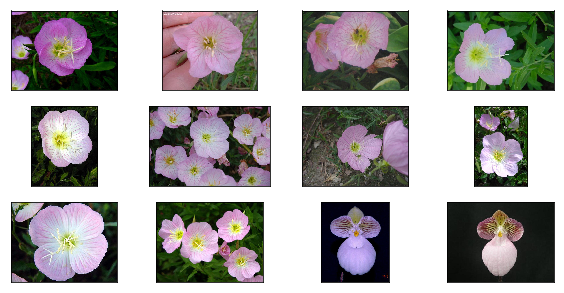

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

tijdregel()

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(10,5))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(training_files[i], ax)


## Step 2: Pre-process the Data

Keras CNNs(when using TensorFlow as backend) require a 4D array (which we'll also refer to as a 4D tensor) as input. The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is 224×224pixels.


In [3]:
#Pre-process the Data

from keras.preprocessing import image                  
from tqdm import tqdm
from IPython.display import display
from PIL import Image
                
Image.LOAD_TRUNCATED_IMAGES = True   


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

---

## Step 5 Create a CNN to classify flowers (transfer learning)

We will now use transfer learning to create a CNN that can identify flowers from images.  The goal is to attain at least 55%(more than the half of 100%) accuracy on the test set.

In this section, you use the bottleneck features from vgg16 pre-trained model. 

## Step 0: Obtain bottleneck features


We first import all necessary data and implement basic settings.

In [5]:
tijdregel()

dir_path = os.path.dirname(os.path.abspath('__file__'))

train_data_dir = os.path.join(dir_path,"data","train")
validation_data_dir = os.path.join(dir_path,"data","validation")
test_data_dir = os.path.join(dir_path,"data","test")


=============================== 2018-01-27 09:40 ===============================


Extracting bottleneck features can take a long time. The bottleneck features that the VGG model produces, depend on the shape of the input, in our case the size of the image. While we standardize all the input images to a specific size, we want to vary the specified size. This done for speedup while testing this notebooks code, and to run the notebook in computers with smaller RAM.   
The code below ensures that the bottleneck features and their labels are stored according to image size. If features and labels in a certain size are already available, they are read from file. Otherwise, they are generated and written to disk.
If you want to re-generate bottleneck features, remove them (or at least one of them).

In [6]:
#save_bottleneck_features

# dimensions of our images.
#img_width = 224
#img_height = 224

# batch size used by flow_from_directory and predict_generator (larger is not faster on cpu, probably on gpu)
batch_size = 4

def make_bottleneck_features(data_dir, label, save_dir, target_size, batch_size=32, save_only=False):
    
    bottleneck_features_file = os.path.join(save_dir,feat_fname(label))
    bottleneck_labels_file = os.path.join(save_dir,label_fname(label))
    
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(data_dir,
                                        target_size=target_size,
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)
    nr_images = len(generator.filenames)
    nr_classes = len(generator.class_indices)
    bottleneck_labels = to_categorical(generator.classes)  

    model = applications.VGG16(include_top=False, weights='imagenet')
    
    predict_size = int(math.ceil(nr_images / float(batch_size)))
    bottleneck_features = model.predict_generator(generator, predict_size, verbose=1)
    
    np.save(open(bottleneck_features_file, 'wb'), bottleneck_features)
    np.save(open(bottleneck_labels_file, 'wb'), bottleneck_labels)
    
    print("saved bottleneck_features",bottleneck_features_file)
    print("saved bottleneck_labels",bottleneck_labels_file)
    if save_only:
        return
    else:
        return bottleneck_features, bottleneck_labels

def feat_fname(dataset):
    assert dataset in ["train","validation","test"]
    fname = "bottleneck_features_"+dataset+"_"+size_str()+".npy"
    return fname

def label_fname(dataset):
    assert dataset in ["train","validation","test"]
    fname = "bottleneck_labels_"+dataset+"_"+size_str()+".npy"
    return fname
    
tijdregel() 
# if all the bottleneck files are already there, we can save a lot of time in testing and tweaking!
try:
    bottleneck_features_train = np.load(feat_fname('train'))
    train_labels = np.load(label_fname('train'))
    bottleneck_features_validation = np.load(feat_fname("validation"))
    validation_labels = np.load(label_fname("validation"))
    bottleneck_features_test = np.load(feat_fname('test'))
    test_labels = np.load(label_fname('test'))
    print("Succeeded to read bottleneck_features from saved files")
except:
    print("Reading bottleneck_features from saved files did not succeed.")
    print("Re-making bottleneck_features can take some time.")
    bottleneck_features_train, train_labels = make_bottleneck_features(train_data_dir,"train", 
                                                                   os.getcwd(), 
                                                                   (img_width, img_height), batch_size)
    tijdregel()
    bottleneck_features_validation, validation_labels = make_bottleneck_features(validation_data_dir,"validation", 
                                                                    os.getcwd(), 
                                                                    (img_width, img_height), batch_size)
    tijdregel()
    bottleneck_features_test, test_labels = make_bottleneck_features(test_data_dir,"test", os.getcwd(), 
                                                                   (img_width, img_height), batch_size)

print("Done!")

=============================== 2018-01-27 09:40 ===============================
Succeeded to read bottleneck_features from saved files
Done!


In [7]:
tijdregel()


print("Data ready")

=============================== 2018-01-27 09:40 ===============================
Data ready


## Step 1: Implement the Model Architecture

In this architecture, the last convolutional output is fed as input to our model. We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each flower category and is equipped with a softmax.

The approach with this architecture is basically the same as with CNN as described above. Only, the basic adaptations for this architecture are:

-Reduce the number of layers, increase the general depth of the networks and the fully connected layer is equipped with a softmax.

In [10]:
tijdregel()

#vgg16_model = Sequential() 
#vgg16_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
#vgg16_model.add(Dropout(.7)) # make this higher for larger images (+/- 0.9 for 168) if there is a single last layer
#vgg16_model.add(Dense(nr_classes, activation='relu'))
#vgg16_model.add(Dropout(.5)) 
#vgg16_model.add(Dense(nr_classes, activation='softmax')) 
### end of last layer

vgg16_model = Sequential()
vgg16_model.add(GlobalAveragePooling2D(input_shape=bottleneck_features_train.shape[1:]))
vgg16_model.add(Dense(nr_classes, activation='softmax'))


print("Model summary:")
vgg16_model.summary() 


=============================== 2018-01-27 09:41 ===============================
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               52326     
Total params: 52,326
Trainable params: 52,326
Non-trainable params: 0
_________________________________________________________________


In [11]:
# compiling
tijdregel()
vgg16_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

=============================== 2018-01-27 09:41 ===============================


## Step 2: Train the Model

In [12]:
# Training and saving the model with the best validation loss
tijdregel()

epochs = 50 
batch_size = 4



vgg16_weights_file=os.path.join(os.getcwd(),"saved_models","weights.best.vgg16.hdf5")

checkpointer = ModelCheckpoint(vgg16_weights_file, verbose=1, save_best_only=True)
callbacks_list = [checkpointer]

myhistory = vgg16_model.fit(bottleneck_features_train, train_labels,
          epochs=epochs, batch_size=batch_size, 
          validation_data=(bottleneck_features_validation, validation_labels),
          callbacks=[checkpointer], verbose=1)

=============================== 2018-01-27 09:41 ===============================
Train on 1020 samples, validate on 1020 samples
Epoch 1/50
1020/1020 [==============================] - 2s 2ms/step - loss: 4.7770 - acc: 0.0343 - val_loss: 4.2680 - val_acc: 0.1157
Epoch 2/50
1020/1020 [==============================] - 1s 1ms/step - loss: 4.1163 - acc: 0.1549 - val_loss: 3.8991 - val_acc: 0.2353
Epoch 3/50
1020/1020 [==============================] - 1s 1ms/step - loss: 3.6726 - acc: 0.2824 - val_loss: 3.5432 - val_acc: 0.2902
Epoch 4/50
1020/1020 [==============================] - 1s 1ms/step - loss: 3.2845 - acc: 0.3716 - val_loss: 3.2948 - val_acc: 0.3098
Epoch 5/50
1020/1020 [==============================] - 1s 1ms/step - loss: 2.9368 - acc: 0.4569 - val_loss: 3.0983 - val_acc: 0.4059
Epoch 6/50
1020/1020 [==============================] - 1s 1ms/step - loss: 2.6814 - acc: 0.5176 - val_loss: 2.9113 - val_acc: 0.4098
Epoch 7/50
1020/1020 [==============================] - 1s 1ms/step

Epoch 24/50
1020/1020 [==============================] - 1s 982us/step - loss: 0.9995 - acc: 0.8088 - val_loss: 1.8315 - val_acc: 0.5696
Epoch 25/50
1020/1020 [==============================] - 1s 1ms/step - loss: 0.9564 - acc: 0.8235 - val_loss: 1.8122 - val_acc: 0.5598
Epoch 26/50
1020/1020 [==============================] - 1s 1ms/step - loss: 0.9109 - acc: 0.8373 - val_loss: 1.8088 - val_acc: 0.5598
Epoch 27/50
1020/1020 [==============================] - 2s 1ms/step - loss: 0.9057 - acc: 0.8255 - val_loss: 1.7962 - val_acc: 0.5627
Epoch 28/50
1020/1020 [==============================] - 1s 1ms/step - loss: 0.8742 - acc: 0.8412 - val_loss: 1.7829 - val_acc: 0.5627
Epoch 29/50
1020/1020 [==============================] - 1s 966us/step - loss: 0.8514 - acc: 0.8363 - val_loss: 1.7630 - val_acc: 0.5578
Epoch 30/50
1020/1020 [==============================] - 1s 953us/step - loss: 0.8418 - acc: 0.8382 - val_loss: 1.7588 - val_acc: 0.5735
Epoch 31/50
1020/1020 [==========================

Epoch 50/50
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5836 - acc: 0.8745 - val_loss: 1.6804 - val_acc: 0.5873


In [13]:
### Load the model weights with the best validation loss.

vgg16_model.load_weights(vgg16_weights_file)

## Step 3: Calculating calculation accuracy on the test dataset





Vgg16 weights have been incorporated using bottleneck features. I have got the vgg16 fitted model of
training and validation set. I want to predict using the test data. 


=============================== 2018-01-27 09:43 ===============================


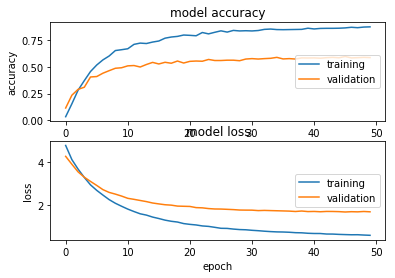

=============================== 2018-01-27 09:43 ===============================
Evaluation with test dataset
6149/6149 [==============================] - 0s 77us/step
Loss = 1.8883, Accuracy = 0.5676


In [14]:
tijdregel()
def plot_learning_history(history):
    assert type(history) is keras.callbacks.History
    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='center right')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='center right')
    plt.show()


plot_learning_history(myhistory)
# Evaluate model with test data set
#evaluation = vgg16_model.evaluate_generator(datagen.flow(bottleneck_features_test, test_label,
#                                                         batch_size=batch_size, shuffle=False),
#                                                         steps=bottleneck_features_test.shape[0] // batch_size, workers=4)
tijdregel()
print("Evaluation with test dataset")
evaluation = vgg16_model.evaluate(bottleneck_features_test, test_labels, batch_size=128, verbose=1)
# Print out final values of all metrics
key2name = {'acc':'Accuracy', 'loss':'Loss', 'val_acc':'Validation Accuracy', 'val_loss':'Validation Loss'}
results = []
for i,key in enumerate(vgg16_model.metrics_names):
    results.append('%s = %.4f' % (key2name[key], evaluation[i]))
    
print(", ".join(results))

---
## PART 4: Algorithm for the App


We should Predict flower type with the Model by writing a function that takes an image path as input and returns the flower type that is predicted by our model:
first, we extract the bottleneck features corresponding to the chosen CNN model;
second, we supply the bottleneck features as input to the model to return the predicted vector;
(the argmax of this prediction vector gives the index of the predicted flower type);
third, we use the flowers' names array defined below to return the corresponding type.


## Step 0: Load the list of flowers' names

In [15]:
flower_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 
    'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 
    'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 
    'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 
    'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 
    'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 
    'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 
    'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 
    'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 
    'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 
    'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 
    'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 
    'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 
    'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 
    'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 
    'trumpet creeper', 'blackberry lily']

## Step 1: Extract bottleneck features

In [16]:
'''
Below is a function to extract the bottleneck features. To obtain the bottleneck features corresponding 
to our CNN architecture, you need to use a function.
'''

from keras.applications.vgg16 import VGG16, preprocess_input

my_headless_VGG16 = VGG16(weights='imagenet', include_top=False)

def extract_VGG16(tensor):
    return my_headless_VGG16.predict(preprocess_input(tensor))

## Step 2:  Predict flowers

In [17]:
'''
To predict a flower we make a function that takes a path to an image as input and returns the flower 
that is predicted by the model; returns "True" if a flower is detected in the image stored at img_path.
'''

def flower_predictor(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = vgg16_model.predict(bottleneck_feature)
    
    if max(predicted_vector[0]) > 0:
        print(max(predicted_vector[0]), flower_names[np.argmax(predicted_vector[0])])
    low_probability = max(predicted_vector[0]) < .05
    # return flower type that is predicted by the model
    if low_probability:
        return False
    else:
        return flower_names[np.argmax(predicted_vector[0])]


## Step 3:  Write Algorithm

We then write an algorithm that accepts a file path to an image and first determines whether the image contains a flower or not, then, return the predicted type provide output that indicates an error.


In [20]:
import cv2
import scipy.misc
import matplotlib.pyplot as plt
import string
%matplotlib inline

def get_reference_image(flower_species, collection="test",randomchoice=True):
    if type(flower_species) is int:
        #we're getting an index
        flower_species = str(flower_species)
    else:
        #we're getting a name
        flower_species = str(flower_names.index(flower_species))
        
    all_of_the_images = os.listdir(os.path.join(os.getcwd(),"data",collection,flower_species))
    if randomchoice:
        chosen = random.choice(all_of_the_images)
    else:
        chosen = all_of_the_images[0]
    return os.path.join(os.getcwd(),"data",collection,flower_species,chosen)

    
def algorithm_predictor(img_path, show_graphics=True, show_flower=True):
    predict = flower_predictor(img_path)
    if predict:
        print("This flower looks like a {}!".format(predict))
        if show_graphics:
            plaatje = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            plt.imshow(cv2.resize(plaatje, (102, 102)))
            plt.show()
        if show_flower:
            plaatje = cv2.cvtColor(cv2.imread(get_reference_image(predict)), cv2.COLOR_BGR2RGB)
            plt.imshow(cv2.resize(plaatje, (102, 102)))
            plt.show()
        return ["flower", predict]

    else:
        print('Sorry, no match found!') 
        if show_graphics:
            plaatje = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            plt.imshow(cv2.resize(plaatje, (102, 102)))
            plt.show()

        return ["Not identified","Not identified"]

## Step 4:  Test the Algorithm

In this section, the new algorithm will be tested! does the algorithm predict flowers accurately? If we have for example a plant does it mistakenly think that it is a flower?

For that purpose, we will be testing our Algorithm on Sample Images! 7 images from the computer.


=============================== 2018-01-27 09:44 ===============================
1.0 giant white arum lily
This flower looks like a giant white arum lily!


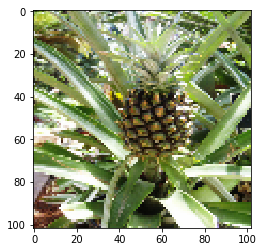

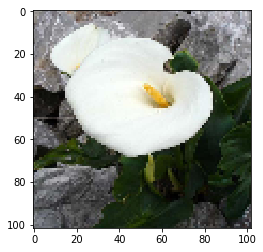

0.999989 bee balm
This flower looks like a bee balm!


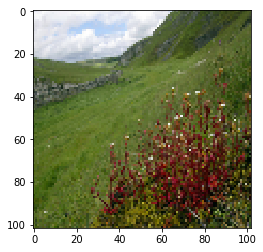

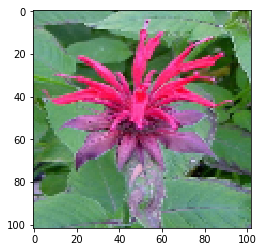

1.0 sweet william
This flower looks like a sweet william!


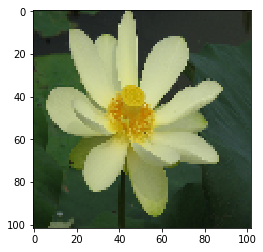

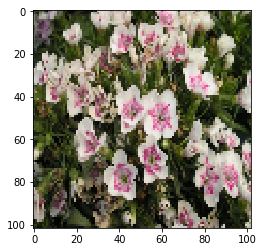

1.0 sweet william
This flower looks like a sweet william!


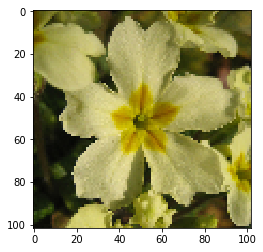

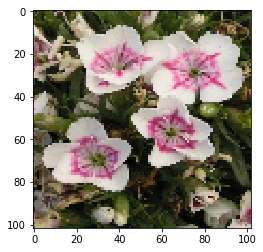

1.0 wild pansy
This flower looks like a wild pansy!


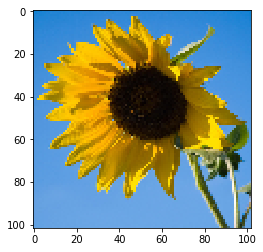

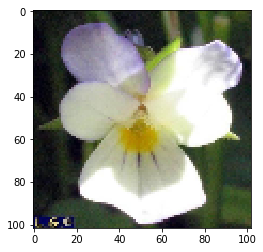

1.0 water lily
This flower looks like a water lily!


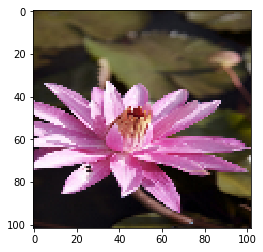

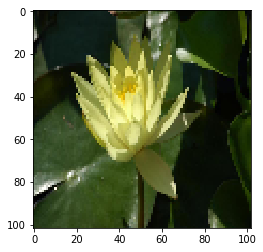

0.999934 tree poppy
This flower looks like a tree poppy!


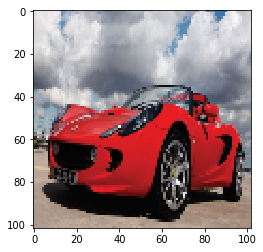

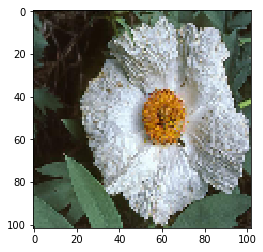

[['flower', 'giant white arum lily'], ['flower', 'bee balm'], ['flower', 'sweet william'], ['flower', 'sweet william'], ['flower', 'wild pansy'], ['flower', 'water lily'], ['flower', 'tree poppy']]


In [21]:
import numpy as np
import cv2
import scipy
from scipy.misc import imread
import matplotlib.pyplot as plt
import os
%matplotlib inline

tijdregel()
pics = ['pictures/ananas.jpeg', 'pictures/landscape.jpeg', 'pictures/lotus.jpeg', 'pictures/primula.jpeg',
           'pictures/sunflower.jpeg', 'pictures/water_lily.jpeg', 'pictures/car.jpeg']  


# testing the algorithm
results = []  
for picture in pics:
    if os.path.exists(picture):
        test = algorithm_predictor(picture, show_graphics=True, show_flower=True)
        results.append(test)
    else:
        print("picture path is false",picture)
    
print(results)


** References **

http://www.robots.ox.ac.uk/~vgg/data/flowers/102/

(https://www.statista.com/statistics/330695/number-of-smartphone-users-worldwide/)

https://github.com/fchollet/keras/tree/master/keras/applications)

https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

http://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

https://machinelearningmastery.com/check-point-deep-learning-models-keras/


Udacity's course material(Deep Learning):

-cifar10_augmentation.ipynb

-cifar10_cnn.ipynb

-conv_visualization.ipynb

-transfer_learning.ipynb

-My Dog breed App project

https://www.quora.com/Do-convolutional-neural-networks-work-better-on-image-classification-problems-than-recurrent-neural-networks

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html

https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069

https://keras.io/preprocessing/image/

http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html
    